In [1]:
import cv2 as cv
import numpy as np


In [2]:
# Start by getting the params from my_cam_matrix.npz
npz_calib = np.load('pics/my_cam_matrix.npz')

# print(npz_calib)

# Get the camera matrix and distortion coefficients
camera_matrix = npz_calib['mtx']
dist_coeffs = npz_calib['dist']

# Get all jpg files in pics/
import os
pics = [f for f in os.listdir('pics/') if f.endswith('.jpg') and f.startswith('2024')]

undist_pics = []

# Loop through all the pics
for pic in pics:
    # Read the image
    img = cv.imread('pics/' + pic)

    img = cv.resize(img, (640, 480))
    # Get the shape of the image
    h, w = img.shape[:2]
    # Get the new camera matrix
    # new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    # Undistort the image
    undistorted_img = cv.undistort(img, camera_matrix, dist_coeffs)#, None, new_camera_matrix)

    # img_grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # undistorted_img_grey = cv.cvtColor(undistorted_img, cv.COLOR_BGR2GRAY)

    # diff = cv.absdiff(img_grey, undistorted_img_grey)

    # cv.imshow('Difference', diff)


    # Save the undistorted image
    # cv.imwrite('pics/undistorted_' + pic, undistorted_img)
    undist_pics.append('undistorted_' + pic)
    # Show the undistorted image
    # cv.imshow('Undistorted Image', undistorted_img)
    if cv.waitKey(0) & 0xFF == ord('q'):
        break
    
cv.destroyAllWindows()

In [3]:
# Get the reb and blue channels and see the difference



for pic in undist_pics:
    img = cv.imread('pics/' + pic)

    red = img[:,:,2]

    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    blue = cv.inRange(hsv, (100, 50, 50), (130, 255, 255))

    # blue = img[:,:,0]

    both = np.hstack((red, blue))

    cv.imshow('Red and Blue', both)

    if cv.waitKey(0) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()



qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/b-ry-jr/Documents/GitHub/Chess_Sight/.venv/lib/python3.10/site-packages/cv2/qt/plugins"


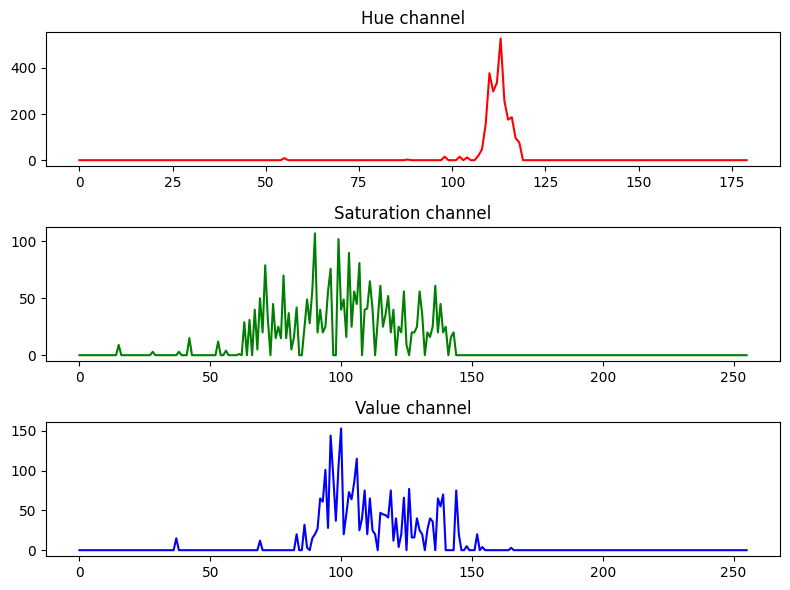

In [16]:
# Show the photo and the different hsv and rgb otpions as sliders
from matplotlib import pyplot as plt

# Read the image
image = cv.imread('blue.png')

# Convert BGR to HSV
hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

# Compute the histogram of the hue channel
hist_h = cv.calcHist([hsv], [0], None, [180], [0, 180])
hist_s = cv.calcHist([hsv], [1], None, [256], [0, 256])
hist_v = cv.calcHist([hsv], [2], None, [256], [0, 256])

# Visualize the histogram
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].plot(hist_h, color='r')
ax[0].set_title('Hue channel')
ax[1].plot(hist_s, color='g')
ax[1].set_title('Saturation channel')
ax[2].plot(hist_v, color='b')
ax[2].set_title('Value channel')
plt.tight_layout()
plt.show()


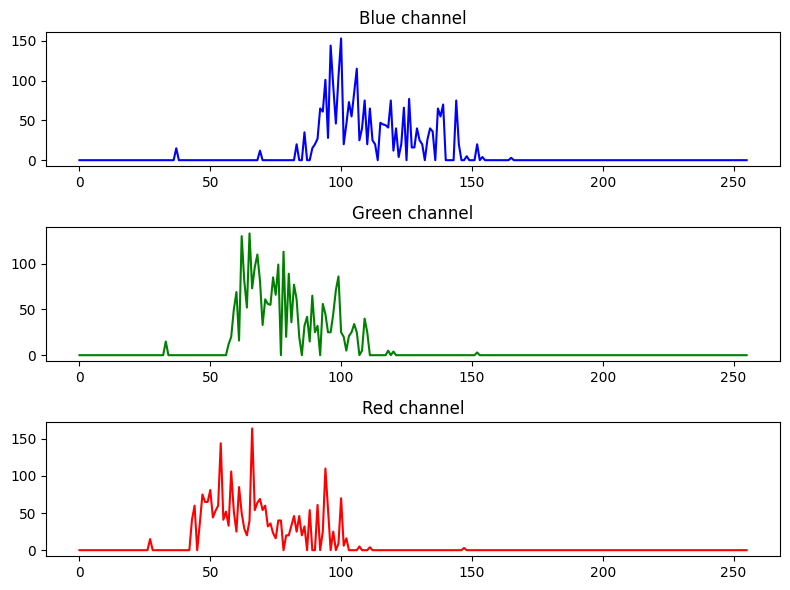

In [17]:
# Now do the same thing for rgb
# Compute the histogram of the hue channel

hist_b = cv.calcHist([image], [0], None, [256], [0, 256])
hist_g = cv.calcHist([image], [1], None, [256], [0, 256])
hist_r = cv.calcHist([image], [2], None, [256], [0, 256])

# Visualize the histogram
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].plot(hist_b, color='b')
ax[0].set_title('Blue channel')
ax[1].plot(hist_g, color='g')
ax[1].set_title('Green channel')
ax[2].plot(hist_r, color='r')
ax[2].set_title('Red channel')
plt.tight_layout()
plt.show()


In [3]:
import imutils

# debug = True

def align_images(image, template, maxFeatures=50, keepPercent=0.2, debug=True):
    image_grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    template_grey = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    orb = cv.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(image_grey, None)
    (kpsB, descsB) = orb.detectAndCompute(template_grey, None)

    method = cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    matches = sorted(matches, key=lambda x:x.distance)

    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]

    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv.drawMatches(image, kpsA, template, kpsB, matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv.imshow("Matched Keypoints", matchedVis)
        cv.waitKey(1)

    # allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt

    # compute the homography matrix between the two sets of matched
	# points
    (H, mask) = cv.findHomography(ptsA, ptsB, method=cv.RANSAC)
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv.warpPerspective(image, H, (w, h))

    # return the aligned image
    return aligned

In [4]:
def align_red_images(image, template, maxFeatures=500, keepPercent=0.2, debug=True):
    image_grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    template_grey = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hsv_template = cv.cvtColor(template, cv.COLOR_BGR2HSV)

    green = cv.inRange(hsv, (50, 50, 50), (70, 255, 255))
    green_template = cv.inRange(hsv_template, (50, 50, 50), (70, 255, 255))

    # Use SIFT instead of ORB
    sift = cv.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(green, None)
    kp2, des2 = sift.detectAndCompute(green_template, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # Store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.95*n.distance:
            good.append(m)

    # check to see if we should visualize the matched keypoints
    if debug:
        matchedVis = cv.drawMatches(green, kp1, green_template, kp2, good, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv.imshow("Matched Keypoints", matchedVis)
        cv.waitKey(1)

    if len(good) > 4:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        h,w = template.shape[:2]
        aligned = cv.warpPerspective(image, H, (w,h))

        return aligned
    
    return None

In [22]:
template = cv.imread('pics/template.jpg')

for pic in undist_pics:
    img = cv.imread('pics/' + pic)
    aligned = align_images(img, template)#, debug=False)
    cv.imshow('Aligned', aligned)
    if cv.waitKey(0) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()

In [14]:
for pic in undist_pics:
    img = cv.imread('pics/' + pic)
    
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    green = cv.inRange(hsv, (50, 50, 50), (70, 255, 255))

    cv.imshow('Green', green)
    if cv.waitKey(0) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()

In [9]:
# Let's try to find the largest rectangle in each image and crop it to that rectangle
for pic in undist_pics:
    img = cv.imread('pics/' + pic)

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    edges = cv.Canny(gray, 50, 150, apertureSize=3)

    # hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # green = cv.inRange(hsv, (50, 50, 50), (70, 255, 255))

    # Find the contours
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Remove any contours larger than 80% of the image width
    contours = [c for c in contours if cv.contourArea(c) < 0.8 * img.shape[1]]

    for contour in contours:
        cv.drawContours(img, [contour], 0, (0, 255, 0), 2)

    cv.imshow('Contours', img)


    # # Get the largest contour
    # largest_contour = max(contours, key=cv.contourArea)

    # # Get the bounding rectangle
    # x, y, w, h = cv.boundingRect(largest_contour)

    # # Crop the image
    # cropped = img[y:y+h, x:x+w]

    # cv.imshow('Cropped', cropped)
    if cv.waitKey(0) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()